<a href="https://colab.research.google.com/github/Altaieb-Mohammed/lab_2corse/blob/master/lab8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


KNN results:
Accuracy: 0.8980

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1000
           1       0.93      0.86      0.89      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000

Confusion matrix:
[[935  65]
 [139 861]]

Weighted KNN results:
Accuracy: 0.9010

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1000
           1       0.93      0.87      0.90      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000

Confusion matrix:
[[933  67]
 [131 869]]

Parzen Window results:
Accuracy: 0.9005

Classification report:
              precision    recall  f1-score   support

           0       0.87  

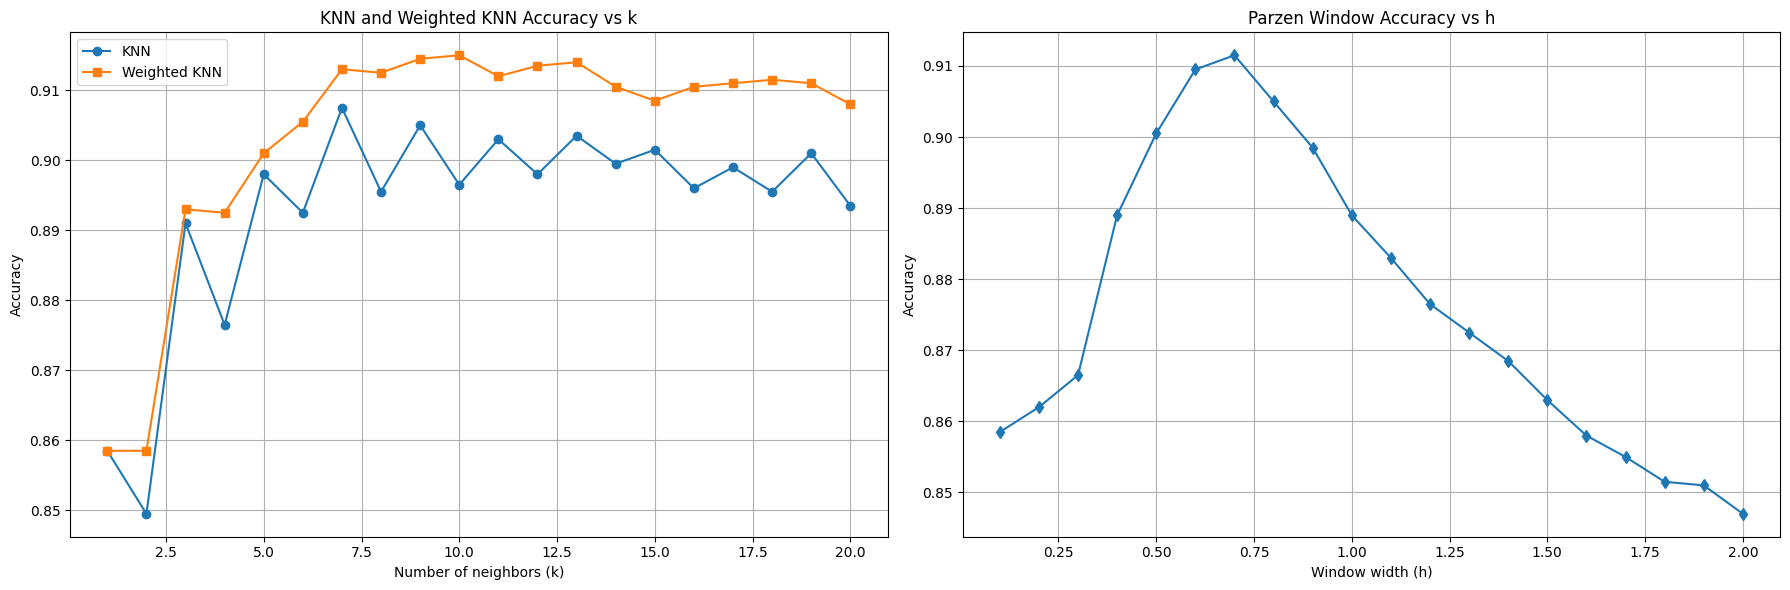

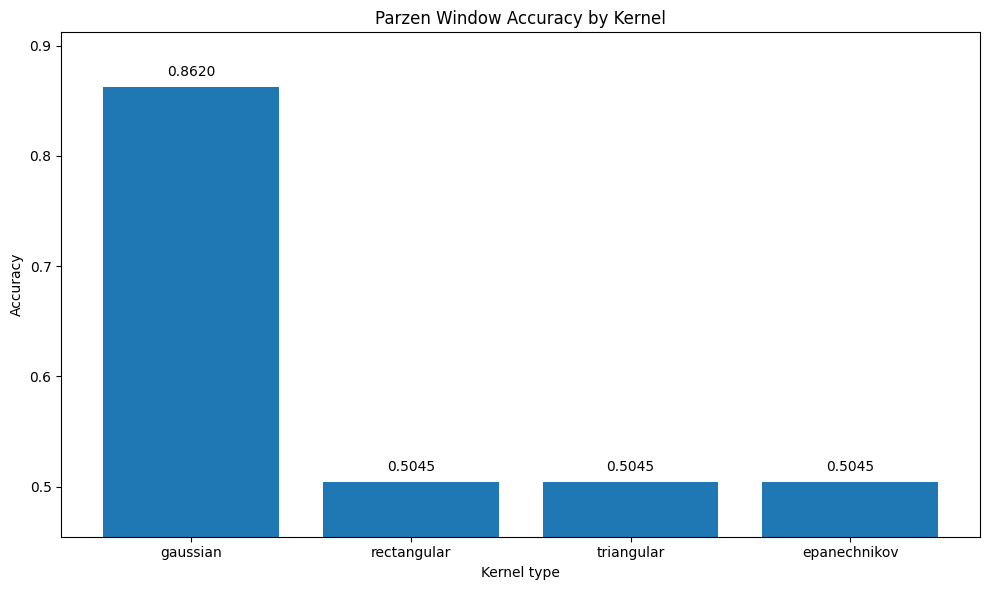

In [1]:
# Импортируем нужные библиотеки для работы с данными и классификацией
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.spatial.distance import cdist

# --- Загрузка и подготовка данных ---
url = "https://raw.githubusercontent.com/Altaieb-Mohammed/lab_2corse/master/inheritance_combined.csv"
df = pd.read_csv(url)

# Если целевой признак отсутствует, создаём бинарный по медиане 'bequests'
if 'high_bequest' not in df.columns:
    median_bequest = df['bequests'].median()
    df['high_bequest'] = (df['bequests'] >= median_bequest).astype(int)

# Выбираем признаки и целевой столбец
feature_cols = ['debts', 'bequests', 'wife', 'husband', 'sons', 'daughters', 'father', 'mother', 'brothers', 'sisters']
df = df[feature_cols + ['high_bequest']].dropna()

# Отделяем признаки и целевой признак
X = df[feature_cols].values
y = df['high_bequest'].values

# Делим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Стандартизируем признаки для корректной работы моделей
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- Реализация KNN ---
class KNN:
    def __init__(self, n_neighbors=5, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.metric = metric

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self

    def predict(self, X):
        y_pred = []
        distances = cdist(X, self.X_train, metric=self.metric)
        for i in range(len(X)):
            nearest_indices = np.argsort(distances[i])[:self.n_neighbors]
            nearest_classes = self.y_train[nearest_indices]
            unique_classes, counts = np.unique(nearest_classes, return_counts=True)
            y_pred.append(unique_classes[np.argmax(counts)])
        return np.array(y_pred)

# --- Реализация Weighted KNN ---
class WeightedKNN:
    def __init__(self, n_neighbors=5, metric='euclidean', weight_function='inverse'):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.weight_function = weight_function

    def _calculate_weights(self, distances):
        if self.weight_function == 'inverse':
            return 1 / (distances + 1e-10)
        elif self.weight_function == 'gaussian':
            return np.exp(-distances**2)
        else:
            raise ValueError(f"Unknown weight function: {self.weight_function}")

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self

    def predict(self, X):
        y_pred = []
        distances = cdist(X, self.X_train, metric=self.metric)
        for i in range(len(X)):
            sorted_indices = np.argsort(distances[i])
            nearest_indices = sorted_indices[:self.n_neighbors]
            nearest_distances = distances[i][nearest_indices]
            nearest_classes = self.y_train[nearest_indices]
            weights = self._calculate_weights(nearest_distances)
            classes = np.unique(self.y_train)
            class_weights = np.zeros(len(classes))
            for j, cls in enumerate(classes):
                class_weights[j] = np.sum(weights[nearest_classes == cls])
            y_pred.append(classes[np.argmax(class_weights)])
        return np.array(y_pred)

# --- Реализация Parzen Window ---
class ParzenWindow:
    def __init__(self, h=1.0, kernel='gaussian'):
        self.h = h
        self.kernel = kernel

    def _kernel_function(self, distances):
        normalized = distances / self.h
        if self.kernel == 'gaussian':
            return np.exp(-0.5 * normalized**2) / np.sqrt(2 * np.pi)
        elif self.kernel == 'rectangular':
            return np.where(np.abs(normalized) <= 1, 0.5, 0)
        elif self.kernel == 'triangular':
            return np.maximum(0, 1 - np.abs(normalized))
        elif self.kernel == 'epanechnikov':
            return np.maximum(0, 0.75 * (1 - normalized**2))
        else:
            raise ValueError(f"Unknown kernel: {self.kernel}")

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.classes = np.unique(y)
        return self

    def predict(self, X):
        y_pred = []
        distances = cdist(X, self.X_train, metric='euclidean')
        for i in range(len(X)):
            kernel_vals = self._kernel_function(distances[i])
            class_scores = np.zeros(len(self.classes))
            for j, cls in enumerate(self.classes):
                mask = (self.y_train == cls)
                class_scores[j] = np.sum(kernel_vals[mask])
            y_pred.append(self.classes[np.argmax(class_scores)])
        return np.array(y_pred)

# --- Оценка модели ---
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{model_name} results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    return accuracy

# --- Эксперименты с гиперпараметрами ---
def experiment_with_hyperparameters(X_train, X_test, y_train, y_test):
    k_values = list(range(1, 21))
    knn_accuracies = []
    wknn_accuracies = []
    h_values = np.linspace(0.1, 2.0, 20)
    parzen_accuracies = []

    for k in k_values:
        knn = KNN(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        knn_accuracies.append(accuracy_score(y_test, y_pred))

        wknn = WeightedKNN(n_neighbors=k)
        wknn.fit(X_train, y_train)
        y_pred = wknn.predict(X_test)
        wknn_accuracies.append(accuracy_score(y_test, y_pred))

    for h in h_values:
        parzen = ParzenWindow(h=h)
        parzen.fit(X_train, y_train)
        y_pred = parzen.predict(X_test)
        parzen_accuracies.append(accuracy_score(y_test, y_pred))

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 2, 1)
    plt.plot(k_values, knn_accuracies, 'o-', label='KNN')
    plt.plot(k_values, wknn_accuracies, 's-', label='Weighted KNN')
    plt.xlabel('Number of neighbors (k)')
    plt.ylabel('Accuracy')
    plt.title('KNN and Weighted KNN Accuracy vs k')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(h_values, parzen_accuracies, 'd-')
    plt.xlabel('Window width (h)')
    plt.ylabel('Accuracy')
    plt.title('Parzen Window Accuracy vs h')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Сравнение разных ядер для окна Парзена
    kernels = ['gaussian', 'rectangular', 'triangular', 'epanechnikov']
    kernel_accuracies = []
    for kernel in kernels:
        parzen = ParzenWindow(h=0.2, kernel=kernel)
        parzen.fit(X_train, y_train)
        y_pred = parzen.predict(X_test)
        kernel_accuracies.append(accuracy_score(y_test, y_pred))

    plt.figure(figsize=(10, 6))
    plt.bar(kernels, kernel_accuracies)
    plt.xlabel('Kernel type')
    plt.ylabel('Accuracy')
    plt.title('Parzen Window Accuracy by Kernel')
    plt.ylim(min(kernel_accuracies) - 0.05, max(kernel_accuracies) + 0.05)
    for i, v in enumerate(kernel_accuracies):
        plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
    plt.tight_layout()
    plt.show()

# --- Основной блок ---
if __name__ == "__main__":
    # Оценка моделей
    evaluate_model(KNN(n_neighbors=5), X_train, X_test, y_train, y_test, "KNN")
    evaluate_model(WeightedKNN(n_neighbors=5), X_train, X_test, y_train, y_test, "Weighted KNN")
    evaluate_model(ParzenWindow(h=0.5), X_train, X_test, y_train, y_test, "Parzen Window")

    # Эксперименты с гиперпараметрами
    experiment_with_hyperparameters(X_train, X_test, y_train, y_test)
